#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import packages

In [ ]:
import numpy as np
import pandas as pd

#Paths setting

In [ ]:
image_path='/content/gdrive/MyDrive/Personalized_Perception/Experiment_dataset/Cat_dataset/'

#Data Loading

## Participant behavior data loading

In [ ]:
rating_sample_data=np.load('/content/gdrive/MyDrive/Personalized_Perception/Observer experiment result/experiment result/Rating sampled experiment data/Rating sample 2000 result.npy',allow_pickle=True).item()

In [ ]:
rating_sample_data.keys()

dict_keys(['Eddy', 'Jack Lo'])

In [ ]:
participant='Eddy'

In [ ]:
len(rating_sample_data[participant])

2000

In [ ]:
classes_distribution={}
class_imgs={}
for img,value in rating_sample_data[participant].items():
  if str(value) not in classes_distribution.keys():
    classes_distribution[f'{value}']=1
    class_imgs[f'{value}']=[img]
  else:
    classes_distribution[f'{value}']+=1
    class_imgs[f'{value}'].append(img)

In [ ]:
classes_distribution

{'1.0': 34,
 '2.0': 215,
 '3.0': 496,
 '4.0': 548,
 '5.0': 479,
 '6.0': 210,
 '7.0': 18}

In [ ]:
class_1=[]
class_2=[]
class_3=[]

for i in range(300):
  if class_imgs['1.0']:
    class_1.append(class_imgs['1.0'].pop())
  elif class_imgs['2.0']:
    class_2.append(class_imgs['2.0'].pop())
  else:
    class_3.append(class_imgs['3.0'].pop())

class_7=[]
class_6=[]
class_5=[]

for i in range(300):
  if class_imgs['7.0']:
    class_7.append(class_imgs['7.0'].pop())
  elif class_imgs['6.0']:
    class_6.append(class_imgs['6.0'].pop())
  else:
    class_5.append(class_imgs['5.0'].pop())

In [ ]:
not_cute_data_train=class_1[:int(len(class_1)*0.8)]+class_2[:int(len(class_2)*0.8)]+class_3[:int(len(class_3)*0.8)]
cute_data_train=class_7[:int(len(class_7)*0.8)]+class_6[:int(len(class_6)*0.8)]+class_5[:int(len(class_5)*0.8)]
not_cute_data_test=class_1[int(len(class_1)*0.8):]+class_2[int(len(class_2)*0.8):]+class_3[int(len(class_3)*0.8):]
cute_data_test=class_7[int(len(class_7)*0.8):]+class_6[int(len(class_6)*0.8):]+class_5[int(len(class_5)*0.8):]

In [ ]:
X_train_data=not_cute_data_train+cute_data_train
Y_train=[1 if i//len(not_cute_data_train) else 0 for i in range(len(cute_data_train)*2)]
X_test_data=not_cute_data_test+cute_data_test
Y_test=[1 if i//len(not_cute_data_test) else 0 for i in range(len(cute_data_test)*2)]

## W+ latent space data loading

In [ ]:
#Loading rating sample W+ latent space data
rating_sample_latent_space=np.load('/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Image latent space data/W+/Rating_experiment_images_W+_latent_space.npy',allow_pickle=True).item()

In [ ]:
len(rating_sample_latent_space)

2000

In [ ]:
rating_sample_latent_space['pixabay_cat_000265.jpg'].shape

(1, 18, 512)

## Obatin each layer W+ latant space for taining data

In [ ]:
X_train_map={f'layer_{i}':[] for i in range(18)}
for img in X_train_data:
  latent_space_set=rating_sample_latent_space[img[7:]]
  for layer, latent_space in zip(X_train_map.keys(),latent_space_set[0]):
    X_train_map[layer].append(latent_space)

X_test_map={f'layer_{i}':[] for i in range(18)}
for img in X_test_data:
  latent_space_set=rating_sample_latent_space[img[7:]]
  for layer, latent_space in zip(X_train_map.keys(),latent_space_set[0]):
    X_test_map[layer].append(latent_space)


In [ ]:
for layer in X_train_map.keys():
  X_train_map[layer]=np.array(X_train_map[layer])
  X_test_map[layer]=np.array(X_test_map[layer])

# SVM training for each layer

## 18 Linear SVM set for each 18 layer of w+ latent space

In [ ]:
from sklearn import svm
from sklearn import metrics

In [ ]:
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (metrics.accuracy_score(y, yPred), 
         metrics.precision_score(y, yPred), 
         metrics.recall_score(y, yPred),
         metrics.f1_score(y, yPred))

def my_scorer(estimator, x, y):
    a, p, r ,f= getScores(estimator, x, y)
    print( a, p, r, f)
    return a,p,r,f

In [ ]:
svm_map={f'layer_{i}':svm.SVC(kernel='linear') for i in range(18)}

## trainging

In [ ]:
result_table={}
style_dir_map={}

for layer, clf in zip(svm_map.keys(),svm_map.values()):
  clf.fit(X_train_map[layer],Y_train)
  y_pred=clf.predict(X_test_map[layer])
  result_table[layer]={}
  result_table[layer]['Accuracy']=metrics.accuracy_score(Y_test, y_pred)
  result_table[layer]['Percision']=metrics.precision_score(Y_test, y_pred)
  result_table[layer]['Recall']=metrics.recall_score(Y_test, y_pred)
  result_table[layer]['F1_Score']=metrics.f1_score(Y_test, y_pred)
  style_dir_map[layer]=clf.coef_[0]

In [ ]:
result_table

{'layer_0': {'Accuracy': 0.5409836065573771,
  'F1_Score': 0.5692307692307692,
  'Percision': 0.5362318840579711,
  'Recall': 0.6065573770491803},
 'layer_1': {'Accuracy': 0.5573770491803278,
  'F1_Score': 0.5846153846153845,
  'Percision': 0.5507246376811594,
  'Recall': 0.6229508196721312},
 'layer_10': {'Accuracy': 0.6885245901639344,
  'F1_Score': 0.712121212121212,
  'Percision': 0.6619718309859155,
  'Recall': 0.7704918032786885},
 'layer_11': {'Accuracy': 0.5491803278688525,
  'F1_Score': 0.5669291338582677,
  'Percision': 0.5454545454545454,
  'Recall': 0.5901639344262295},
 'layer_12': {'Accuracy': 0.5901639344262295,
  'F1_Score': 0.6031746031746033,
  'Percision': 0.5846153846153846,
  'Recall': 0.6229508196721312},
 'layer_13': {'Accuracy': 0.6229508196721312,
  'F1_Score': 0.6229508196721312,
  'Percision': 0.6229508196721312,
  'Recall': 0.6229508196721312},
 'layer_14': {'Accuracy': 0.6065573770491803,
  'F1_Score': 0.6521739130434783,
  'Percision': 0.5844155844155844,


In [ ]:
style_dir_map

{'layer_0': array([ 4.53438235e-01, -4.28645724e-03, -2.50898898e-01,  3.88119268e-01,
         1.29986752e+00,  1.79756680e-01,  3.74308908e-01, -4.75287191e-01,
        -1.86011331e-01, -1.97222117e-01,  4.82089581e-01,  2.87681338e-01,
         4.71742911e-01, -1.20335824e-02, -2.60047099e-01,  4.22018991e-01,
         2.19438020e-01, -1.52856050e-01, -2.46987649e-01,  5.54349177e-01,
        -2.74327084e-01,  2.84343134e-01, -4.02436726e-01, -3.27203679e-02,
        -1.24103509e-01, -2.12065818e-01,  6.82137037e-01,  2.45622322e-01,
         5.85535533e-01, -7.42211977e-02, -2.11240445e-01, -1.56254347e-01,
         3.94779051e-01, -1.29899341e-01, -2.55563804e-01,  7.53188011e-01,
        -3.62164645e-02, -4.86863614e-02, -7.04614429e-01,  2.00334778e-01,
        -3.62817090e-01,  5.60569965e-01, -2.44319511e-01, -3.88382138e-01,
         1.24607122e-02, -1.55318322e-01, -1.73686120e-01,  4.58999330e-01,
        -3.15828660e-01, -2.99384518e-01,  2.00752350e-01,  5.02342944e-01,
 

In [89]:
Top_5_svm={}

for layer, result in result_table.items():
  if len(Top_5_svm)<5:
    Top_5_svm[layer]=svm_map[layer]
  else:
    for index,picked_layer in enumerate(Top_5_svm.keys()):
      if result_table[layer]['Accuracy']>result_table[picked_layer]['Accuracy']:
        del Top_5_svm[picked_layer]
        Top_5_svm[layer]=svm_map[layer]
        break


In [90]:
Top_5_svm

{'layer_10': SVC(kernel='linear'),
 'layer_13': SVC(kernel='linear'),
 'layer_6': SVC(kernel='linear'),
 'layer_8': SVC(kernel='linear'),
 'layer_9': SVC(kernel='linear')}

In [91]:
Top_10_svm={}

for layer, result in result_table.items():
  if len(Top_10_svm)<10:
    Top_10_svm[layer]=svm_map[layer]
  else:
    for index,picked_layer in enumerate(Top_10_svm.keys()):
      if result_table[layer]['Accuracy']>result_table[picked_layer]['Accuracy']:
        del Top_10_svm[picked_layer]
        Top_10_svm[layer]=svm_map[layer]
        break

In [92]:
Top_1_svm={}

for layer, result in result_table.items():
  if len(Top_1_svm)<1:
    Top_1_svm[layer]=svm_map[layer]
  else:
    for index,picked_layer in enumerate(Top_1_svm.keys()):
      if result_table[layer]['Accuracy']>result_table[picked_layer]['Accuracy']:
        del Top_1_svm[picked_layer]
        Top_1_svm[layer]=svm_map[layer]
        break

#Regenerate image from StyleGan2 ADA

##Load StyleGAN-ada Genertor

Download StyleGAN-ada afhqcat model

In [ ]:
%tensorflow_version 1.x
# ! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

TensorFlow 1.x selected.


In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'stylegan2-ada'

!git clone https://github.com/NVlabs/stylegan2-ada.git $CODE_DIR

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.


In [ ]:
%cd /content/stylegan2-ada
import argparse
import os
import pickle
import re

import numpy as np
import PIL.Image

import dnnlib
import dnnlib.tflib as tflib
tflib.init_tf()
print('Loading networks from "%s"...' % 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl')
with dnnlib.util.open_url('https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl') as fp:
        _G, _D, Gs = pickle.load(fp)

/content/stylegan2-ada
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl"...


##Function for style_morphing

In [ ]:
from PIL import Image

In [ ]:
X_train_map['layer_0'][5].shape

(512,)

In [103]:
w_laten_map=np.load('/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Image latent space data/W/rating_experiment_2000_image_W_latent_space_data_map.npy',allow_pickle=True).item()

In [110]:
w_laten_map['pixabay_cat_000270.jpg'][0][0]

array([ 6.68182552e-01, -3.06741804e-01, -6.62819147e-01, -1.15786910e-01,
       -6.24124885e-01,  8.20324481e-01, -5.77290058e-01, -6.74387634e-01,
       -2.23409697e-01, -3.36120248e-01,  6.88909888e-01, -3.93998250e-02,
       -1.23524332e+00,  1.17034173e+00,  7.72276282e-01, -1.95741341e-01,
        3.97581339e-01,  7.42148399e-01, -3.86573315e-01,  7.30161250e-01,
        2.92557925e-02, -4.29129004e-02,  8.37672174e-01,  4.27216858e-01,
        1.08664185e-01, -1.03534496e+00, -7.04061240e-02, -3.46770316e-01,
        8.07788610e-01, -1.02876270e+00,  1.68767786e+00,  3.83222282e-01,
       -6.54418647e-01, -2.45081156e-01,  4.25955594e-01, -2.29414612e-01,
       -5.26679814e-01, -2.34047383e-01,  5.40275693e-01, -2.58056968e-01,
        8.19599807e-01, -9.74913120e-01, -1.11849344e+00,  3.22298408e-01,
       -8.71483088e-01,  4.40695107e-01, -1.26695180e+00, -9.84661400e-01,
        2.93338180e-01, -5.47794223e-01, -4.99197900e-01, -8.70376110e-01,
       -2.99580961e-01, -

In [114]:
# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# seed random number generator
seed(1)
# prepare data
data1 = 20 * randn(1000) + 100
data2 = data1 + (10 * randn(1000) + 50)
# calculate Pearson's correlation
corr, _ = pearsonr(X_train_map[layer][0], X_train_map[layer][3])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.974


In [109]:
X_train_map[layer][0]

array([ 4.49947417e-01, -8.25208545e-01,  3.96169066e-01, -3.21898907e-01,
        4.25030082e-01,  1.08676267e+00,  4.06689137e-01, -3.29909801e-01,
        1.10780209e-01,  3.03517729e-01,  3.39591146e-01,  1.74853772e-01,
        7.40042567e-01,  3.95515591e-01,  2.26622641e-01,  1.93991125e-01,
       -3.56069207e-03, -2.72684783e-01,  3.72390568e-01, -3.18656266e-02,
        2.86947489e-01, -5.41031063e-02,  3.31708610e-01,  2.99056023e-01,
        6.14022613e-02, -4.95013088e-01,  1.14121413e+00, -1.28710508e-01,
        8.43004704e-01,  4.68698591e-02,  1.90995723e-01,  1.22763658e+00,
       -6.83101535e-01, -1.78720474e-01,  4.24754351e-01,  2.07769945e-02,
        6.61160409e-01,  4.12390769e-01,  8.31382930e-01,  2.99369752e-01,
        9.31564391e-01, -1.69790626e-01, -4.74872291e-01,  3.39338839e-01,
        3.22491944e-01,  3.46755028e-01, -3.15944284e-01, -5.48464283e-02,
       -3.30111444e-01, -3.39721888e-01,  2.68104613e-01,  5.17864943e-01,
        2.84813702e-01,  

In [120]:
image_index=[i for i in range(10)]
original_latent=np.zeros((1,18,512))
modified_latent=np.zeros((1,18,512))

original_list=[original_latent.copy() for i in range(len(image_index))]
modified_list=[modified_latent.copy() for i in range(len(image_index))]
result_list=[]
for i in image_index:
  for index, layer in enumerate(X_train_map.keys()):
    original_list[i][0][index]=X_train_map[layer][i]
    modified_list[i][0][index]=X_train_map[layer][i]+style_dir_map[list(Top_1_svm.keys())[0]]*2

    # if layer in Top_10_svm.keys():
    #   print(layer)
    #   modified_list[i][0][index]=X_train_map[layer][i]+style_dir_map[layer]
    # else:
    #   modified_list[i][0][index]=X_train_map[layer][i]

  style_morphing=np.linspace(original_list[i],modified_list[i],num=6)
  result=Gs.components.synthesis.run(style_morphing[0], output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:]
  for index in range(1,len(style_morphing),1):
    result=np.concatenate([result,Gs.components.synthesis.run(style_morphing[index], output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:]],axis=1)
  result_list.append(Image.fromarray(result))

In [121]:
result_list[0]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt

In [101]:

fig, ax = plt.subplots(10,1,figsize=(30,30))

for i in range(10):
  ax[i].grid(False)
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(result_list[i])
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/W+ SVM/Rating experiment result/Eddy/sample_of_style_manipulation_for_all_layer.png')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
result_list[0]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
result_list[1]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_index=5

original_latent=np.zeros((1,18,512))
modified_latent=np.zeros((1,18,512))
result=[]
for index, layer in enumerate(X_train_map.keys()):
  original_latent[0][index]=X_train_map[layer][image_index]
  if layer in Top_1_svm.keys():
    modified_latent[0][index]=X_train_map[layer][image_index]+style_dir_map[layer]
  else:
    modified_latent[0][index]=X_train_map[layer][image_index]

style_morphing=np.linspace(original_latent,modified_latent,num=5)
  

In [ ]:
style_morphing.shape

(5, 1, 18, 512)

In [ ]:
result=np.array([Gs.components.synthesis.run(original_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:]])

In [ ]:
result=np.array(Gs.components.synthesis.run(original_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

for style in style_morphing:
  result=np.concatenate([result,Gs.components.synthesis.run(style, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:]], axis=1)

In [ ]:
#top 1
Image.fromarray(result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#top 10
Image.fromarray(result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#top 5
Image.fromarray(result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#all layer
Image.fromarray(result)

Output hidden; open in https://colab.research.google.com to view.

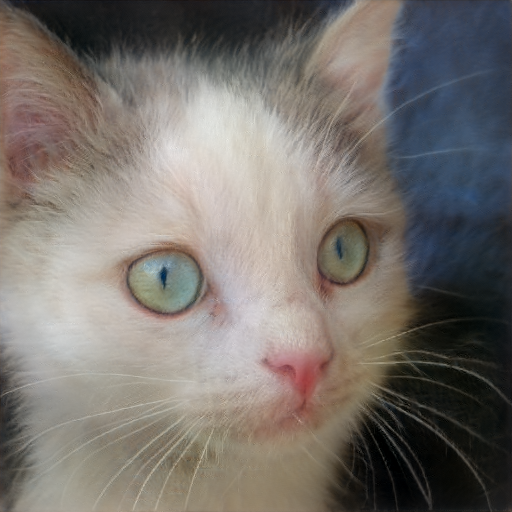

In [ ]:
Image.fromarray(Gs.components.synthesis.run(original_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

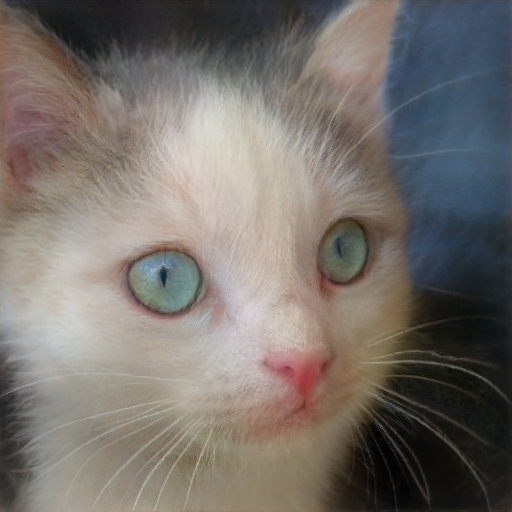

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

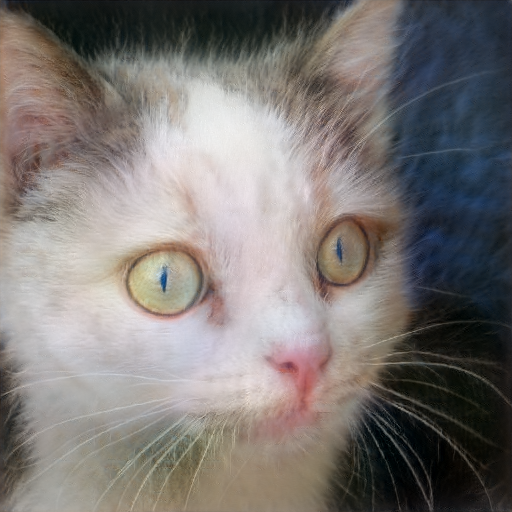

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

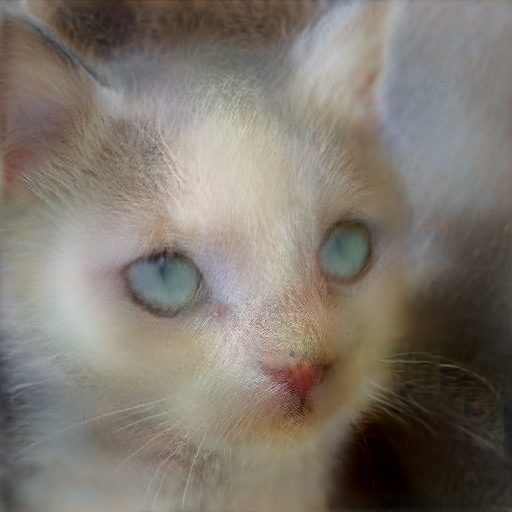

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

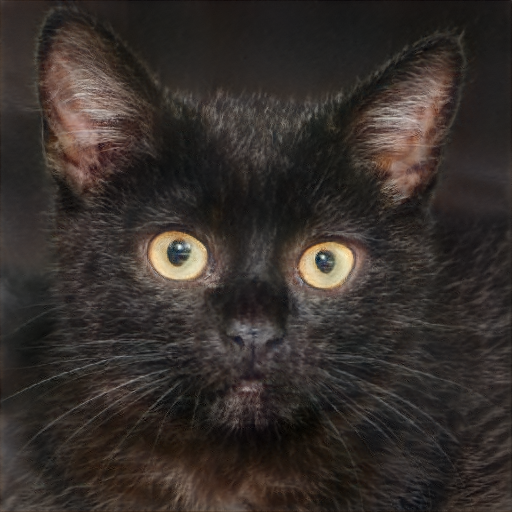

In [ ]:
Image.fromarray(Gs.components.synthesis.run(original_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

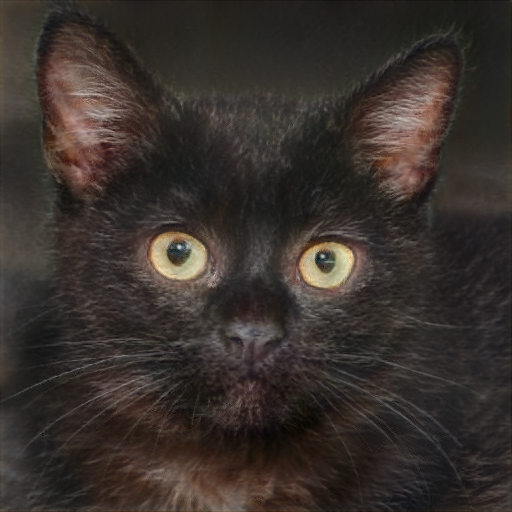

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

In [ ]:
modified_latent

array([[[ 0.20219717,  0.11503425, -1.04817566, ...,  0.33776782,
          2.90676216,  1.16833468],
        [ 1.99982339, -4.04343345, -0.48872798, ..., -0.64898556,
          1.91537402, -0.89549451],
        [-9.02680433, -3.21846636, -5.14612387, ..., -4.96288176,
         -6.14438003,  7.42916705],
        ...,
        [-1.51721229, -0.2965975 ,  1.86176163, ..., -1.04234648,
         -0.64801765, -0.87619012],
        [-1.45328885, -0.78085671, -2.7442986 , ..., -3.44745994,
          3.25425454, -2.37004602],
        [ 0.66988199, -0.13779456,  1.08676164, ...,  0.85043184,
          1.75504866, -0.25678574]]])

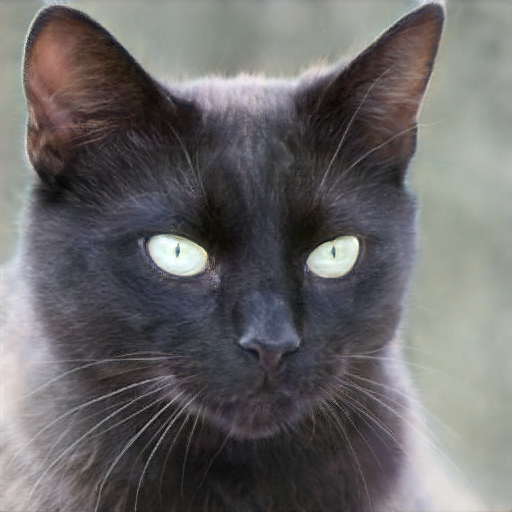

In [ ]:
Image.fromarray(Gs.components.synthesis.run(original_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

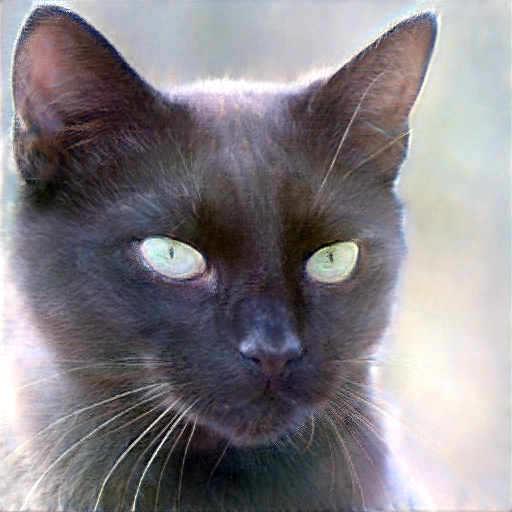

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

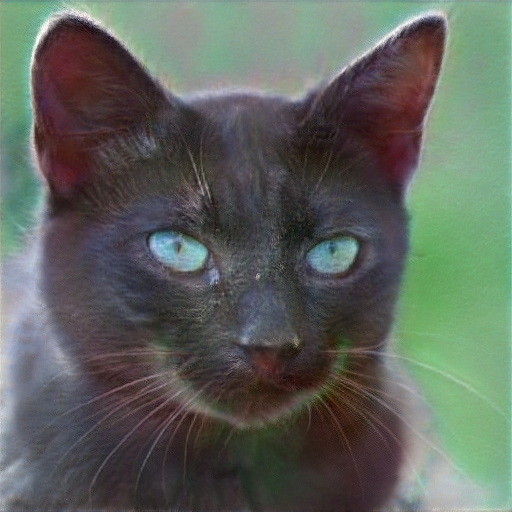

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

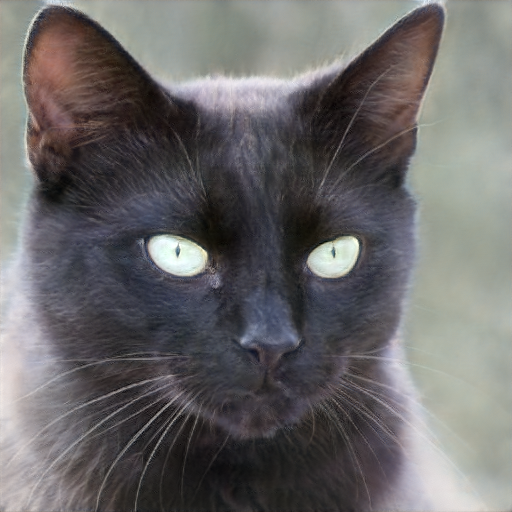

In [ ]:
Image.fromarray(Gs.components.synthesis.run(original_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

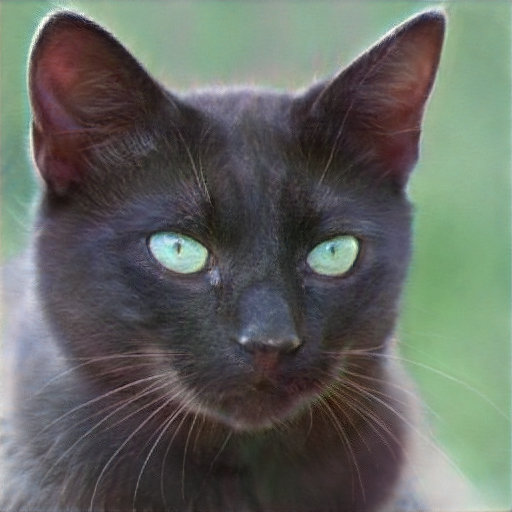

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

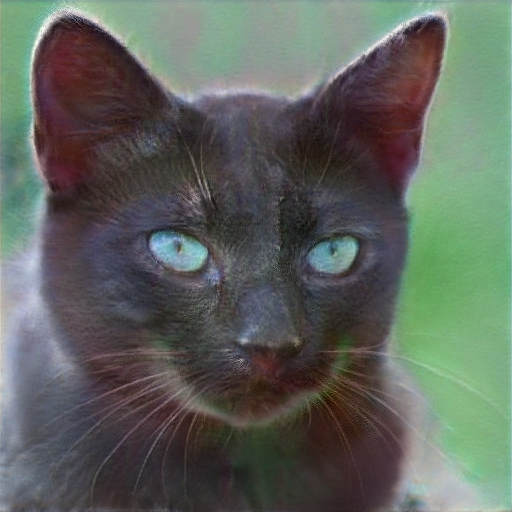

In [ ]:
Image.fromarray(Gs.components.synthesis.run(modified_latent, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])

In [ ]:
def reconstruct_latent_space(latent):
  reconstructed_latent=np.zeros((1,18,512))
  for i in range(len(reconstructed_latent[0])):
      reconstructed_latent[0][i]=latent
  return reconstructed_latent

In [ ]:
def style_morphing(initial_img_latent_space, style_dir, distance, steps):
  """
  Input:
    initial_img_latent_space -> numpy array [1,18,512] shape: the image's W latent space from pSp encoder
    style_dir -> numpy array [1,18,512] shape: the reconstructed SVM coef
    distance -> int: the distance from the SVM dicition boundry
    steps -> int: the morphing steps
  Output:
    morghing_imgs -> numpy array [steps,512,512,3] shape: regenerated image matrix
  """
  target_latent_space=reconstruct_latent_space(style_dir*distance)+reconstruct_latent_space(initial_img_latent_space)
  latent_morphing=np.linspace(initial_img_latent_space, target_latent_space, num=steps)
  # print(latent_morphing.shape)
  morghing_imgs=[]
  for latent_space in latent_morphing:
    morghing_imgs.append(Gs.components.synthesis.run(latent_space, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:])
  return np.array(morghing_imgs)

##Evaluate correct_predicted sample

In [ ]:
cor_predict_img=X_test[[Y_test==y_pred]]
cor_predict_label=Y_test[Y_test==y_pred]

In [ ]:
print(cor_predict_img.shape)
print(cor_predict_label.shape)

In [ ]:
#randomly select five sample from cute data
np.random.seed(2000)
cute_mask=np.ones(cor_predict_label.shape)
cute_imgs=cor_predict_img[cor_predict_label==cute_mask]
cute_d=cor_predict_d[cor_predict_label==cute_mask]
randon_idx=np.random.choice([i for i in range(len(cute_imgs))],size=5,replace=False)

cute_sample=cute_imgs[randon_idx]
cute_sample_d=cute_d[randon_idx]

In [ ]:
#cuter style change
result=[]
result_images=[]
for latent,distance in zip(cute_sample,cute_sample_d):
  morpging_imgs=style_morphing(latent_, style_dir, distance, steps=5)
  image_list=Gs.components.synthesis.run(reconstruct_latent_space(latent), output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:]# add the reconstructed real image
  for i in range(len(morpging_imgs)):
    image_list=np.concatenate([image_list,morpging_imgs[i]], axis=1)
    result_images.append(morpging_imgs[i])
  result.append(Image.fromarray(image_list))

##flatten all layers of latent space

In [ ]:
# flatten all layers of latent space
latent_space_flatten=[]
for latent in rating_sample_latent_space:
  latent_space_flatten.append(latent.flatten())
latent_space_flatten=np.array(latent_space_flatten)

In [ ]:
latent_space_flatten.shape

(2000, 9216)

##flatten custom layers sets of latent space

In [ ]:
# flatten custom layers sets of latent space
layers_sets=[[0,1,2,3,4],
       [5,6,7,8,9],
       [10,11,12,13,14],
       [15,16,17]]
layers_sets_latent_space_flatten={'Layers_0,1,2,3,4':[],
                 'Layers_5,6,7,8,9':[],
                 'Layers_10,11,12,13,14':[],
                 'Layers_15,16,17':[],
                 }




for layers_set,layers_set_name in zip(layers_sets,layers_sets_latent_space_flatten.keys()):
  latent_space_flatten_sets=[]
  for latent in random_sample_latent_space:
    latent_space_flatten=[]
    for layer in layers_set:
      latent_space_flatten.append(latent[:,layer,:].flatten())
    latent_space_flatten_sets.append(np.array(latent_space_flatten).flatten())
  latent_space_flatten_sets=np.array(latent_space_flatten_sets)
  print(latent_space_flatten_sets.shape)
  layers_sets_latent_space_flatten[layers_set_name]=latent_space_flatten_sets

(2000, 2560)
(2000, 2560)
(2000, 2560)
(2000, 1536)


In [ ]:
layers_sets_latent_space_flatten['Layers_0,1,2,3,4'].shape

(2000, 2560)

##flatten each layer of latent space

In [ ]:
# flatten each layer of latent space
latent_space_flatten_each={f'Layer_{i}':[] for i in range(18)}

for layer in range(18):
  for latent in random_sample_latent_space:
    latent_space_flatten_each[f'Layer_{layer}'].append(latent[:,layer,:].flatten())
  latent_space_flatten_each[f'Layer_{layer}']=np.array(latent_space_flatten_each[f'Layer_{layer}'])

In [ ]:
for latent in random_sample_latent_space:
  print(latent[:,layer,:].flatten().shape)
  break

(512,)


In [ ]:
latent_space_flatten_each['Layer_0'].shape

(2000, 512)

# Data Management

In [ ]:
if 'Eddy' in participant:
  label_data=list(random_sample_data[participant].values())[:2000]
else:
  label_data=list(random_sample_data[participant].values())

##split the data into train and validate set (no need to run if testing cross validation)

In [ ]:
like_image_latent_space=[]
dislike_image_latent_space=[]

for latent_space, label in zip(random_sample_latent_space,label_data):
  if label==1:
    like_image_latent_space.append(latent_space.flatten())
  else:
    dislike_image_latent_space.append(latent_space.flatten())

like_image_latent_space=np.array(like_image_latent_space)
dislike_image_latent_space=np.array(dislike_image_latent_space)

In [ ]:
traing_percentage=0.8
testing_percentage=0.2
traning_quantity=int(len(like_image_latent_space)*traing_percentage)# it also is the end point of training data slicing and start point of testing data slicing
testing_quantity=int(len(like_image_latent_space)*testing_percentage)

x_train=np.concatenate((like_image_latent_space[:traning_quantity],dislike_image_latent_space[:traning_quantity]))
y_train=np.concatenate((np.ones(traning_quantity, dtype=int),np.zeros(traning_quantity, dtype=int)))

#shuffle x,y in same order
idx=np.random.choice(range(traning_quantity*2),traning_quantity*2,replace=False)
x_train=x_train[idx]
y_train=y_train[idx]


x_test=np.concatenate((like_image_latent_space[traning_quantity:],dislike_image_latent_space[traning_quantity:]))
y_test=np.concatenate((np.ones(testing_quantity, dtype=int),np.zeros(testing_quantity, dtype=int)))
#shuffle x,y in same order
idx=np.random.choice(range(testing_quantity*2),testing_quantity*2,replace=False)
x_test=x_test[idx]
y_test=y_test[idx]

In [ ]:
print(f'x_train shape:{x_train.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'x_test shape:{x_test.shape}')
print(f'y_test shape:{y_test.shape}')

x_train shape:(1600, 9216)
y_train shape:(1600,)
x_test shape:(400, 9216)
y_test shape:(400,)


#Loading svm from sklearn and training (cross validation)

##Loading packages

In [ ]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_validate

##set up functions and classification model

In [ ]:
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (metrics.accuracy_score(y, yPred), 
         metrics.precision_score(y, yPred), 
         metrics.recall_score(y, yPred),
         metrics.f1_score(y, yPred))

def my_scorer(estimator, x, y):
    a, p, r ,f= getScores(estimator, x, y)
    print( a, p, r, f)
    return a,p,r,f

In [ ]:
clf_map = {'linear_SVC':svm.SVC(kernel='linear'),
       'polynomial_SVC':svm.SVC(kernel='poly',degree=2),
       'rbf_SVC':svm.SVC(),
       'sigmoid_SVC':svm.SVC(kernel='sigmoid')}



###Cross validate with flatten all layers of latent space

In [ ]:
latent_space_flatten.shape

(2000, 9216)

In [ ]:
len(label_data)

2000

In [ ]:
table={'all_layers':{
    'clf_name':[],
    'Accuracy':[],
    'Percision':[],
    'Recall':[],
    'F1_Score':[] }}


for clf_name,clf in clf_map.items():
  scores = cross_validate(clf, latent_space_flatten, label_data, cv=5 ,scoring=('accuracy', 'precision', 'recall', 'f1'))

  table['all_layers']['clf_name'].append(clf_name)
  table['all_layers']['Accuracy'].append("%0.2f +/- %0.2f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
  table['all_layers']['Percision'].append("%0.2f +/- %0.2f" % (scores['test_precision'].mean(), scores['test_precision'].std()))
  table['all_layers']['Recall'].append("%0.2f +/- %0.2f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
  table['all_layers']['F1_Score'].append("%0.2f +/- %0.2f" % (scores['test_f1'].mean(), scores['test_f1'].std()))

In [ ]:
from IPython.display import display

In [ ]:
result_table=pd.DataFrame(table['all_layers'])
display(result_table)

clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.59 +/- 0.02  0.59 +/- 0.03  0.59 +/- 0.04  0.59 +/- 0.01
1  polynomial_SVC  0.60 +/- 0.02  0.59 +/- 0.02  0.67 +/- 0.10  0.63 +/- 0.04
2         rbf_SVC  0.61 +/- 0.03  0.60 +/- 0.03  0.66 +/- 0.10  0.62 +/- 0.05
3     sigmoid_SVC  0.59 +/- 0.02  0.58 +/- 0.02  0.68 +/- 0.08  0.62 +/- 0.03

In [ ]:
result_table.to_csv(f'/content/drive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W+ latent space/SVM/Random sample experiment result/{participant}_all_layers_result.csv',index=False)

###Cross validate with flatten custom layers sets of latent space

In [ ]:
table={f'{layers_sets}':{'clf_name':[],
    'Accuracy':[],
    'Percision':[],
    'Recall':[],
    'F1_Score':[] } for layers_sets in layers_sets_latent_space_flatten.keys()}

for layers_sets,latent_space in layers_sets_latent_space_flatten.items():
  for clf_name,clf in clf_map.items():
    scores = cross_validate(clf, latent_space, label_data, cv=5 ,scoring=('accuracy', 'precision', 'recall', 'f1'))

    table[layers_sets]['clf_name'].append(clf_name)
    table[layers_sets]['Accuracy'].append("%0.2f +/- %0.2f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
    table[layers_sets]['Percision'].append("%0.2f +/- %0.2f" % (scores['test_precision'].mean(), scores['test_precision'].std()))
    table[layers_sets]['Recall'].append("%0.2f +/- %0.2f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
    table[layers_sets]['F1_Score'].append("%0.2f +/- %0.2f" % (scores['test_f1'].mean(), scores['test_f1'].std()))

In [ ]:
from IPython.display import display

In [ ]:
for layer, result in table.items():
  result_table=pd.DataFrame(result)
  print(layer)
  display(result_table)

Layers_0,1,2,3,4


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.02  0.57 +/- 0.02  0.54 +/- 0.04  0.55 +/- 0.02
1  polynomial_SVC  0.56 +/- 0.02  0.54 +/- 0.02  0.71 +/- 0.10  0.61 +/- 0.04
2         rbf_SVC  0.55 +/- 0.03  0.54 +/- 0.02  0.65 +/- 0.12  0.59 +/- 0.06
3     sigmoid_SVC  0.54 +/- 0.02  0.53 +/- 0.01  0.68 +/- 0.13  0.59 +/- 0.07

Layers_5,6,7,8,9


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.55 +/- 0.01  0.55 +/- 0.01  0.56 +/- 0.01  0.56 +/- 0.01
1  polynomial_SVC  0.61 +/- 0.02  0.59 +/- 0.02  0.71 +/- 0.08  0.64 +/- 0.03
2         rbf_SVC  0.62 +/- 0.02  0.61 +/- 0.01  0.67 +/- 0.08  0.63 +/- 0.04
3     sigmoid_SVC  0.60 +/- 0.02  0.59 +/- 0.02  0.63 +/- 0.07  0.61 +/- 0.04

Layers_10,11,12,13,14


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.54 +/- 0.01  0.54 +/- 0.01  0.55 +/- 0.03  0.55 +/- 0.01
1  polynomial_SVC  0.61 +/- 0.03  0.59 +/- 0.03  0.73 +/- 0.06  0.65 +/- 0.02
2         rbf_SVC  0.60 +/- 0.03  0.59 +/- 0.03  0.68 +/- 0.07  0.63 +/- 0.03
3     sigmoid_SVC  0.57 +/- 0.03  0.56 +/- 0.03  0.62 +/- 0.06  0.59 +/- 0.04

Layers_15,16,17


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.55 +/- 0.02  0.55 +/- 0.02  0.58 +/- 0.05  0.57 +/- 0.03
1  polynomial_SVC  0.54 +/- 0.01  0.60 +/- 0.05  0.29 +/- 0.06  0.38 +/- 0.04
2         rbf_SVC  0.55 +/- 0.02  0.57 +/- 0.04  0.43 +/- 0.06  0.48 +/- 0.03
3     sigmoid_SVC  0.47 +/- 0.01  0.47 +/- 0.01  0.46 +/- 0.04  0.46 +/- 0.02

In [ ]:
for layers_sets, result in table.items():
  result_table=pd.DataFrame(result)
  result_table.to_csv(f'/content/drive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W+ latent space/SVM/Random sample experiment result/{participant}_{layers_sets}_result.csv',index=False)

###Cross validate with flatten each layer of latent space

In [ ]:
table={f'Layer_{i}':{'clf_name':[],
    'Accuracy':[],
    'Percision':[],
    'Recall':[],
    'F1_Score':[] } for i in range(18)}

for layer,latent_space in latent_space_flatten_each.items():
  for clf_name,clf in clf_map.items():
    scores = cross_validate(clf, latent_space, label_data, cv=5 ,scoring=('accuracy', 'precision', 'recall', 'f1'))

    table[layer]['clf_name'].append(clf_name)
    table[layer]['Accuracy'].append("%0.2f +/- %0.2f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
    table[layer]['Percision'].append("%0.2f +/- %0.2f" % (scores['test_precision'].mean(), scores['test_precision'].std()))
    table[layer]['Recall'].append("%0.2f +/- %0.2f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
    table[layer]['F1_Score'].append("%0.2f +/- %0.2f" % (scores['test_f1'].mean(), scores['test_f1'].std()))


In [ ]:
from IPython.display import display

In [ ]:
for layer, result in table.items():
  result_table=pd.DataFrame(result)
  print(layer)
  display(result_table)

Layer_0


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.53 +/- 0.01  0.53 +/- 0.01  0.56 +/- 0.09  0.54 +/- 0.05
1  polynomial_SVC  0.52 +/- 0.01  0.51 +/- 0.01  0.89 +/- 0.05  0.65 +/- 0.01
2         rbf_SVC  0.51 +/- 0.03  0.51 +/- 0.02  0.75 +/- 0.10  0.60 +/- 0.04
3     sigmoid_SVC  0.50 +/- 0.03  0.50 +/- 0.03  0.59 +/- 0.04  0.54 +/- 0.03

Layer_1


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.54 +/- 0.02  0.53 +/- 0.02  0.57 +/- 0.07  0.55 +/- 0.04
1  polynomial_SVC  0.54 +/- 0.01  0.53 +/- 0.01  0.73 +/- 0.11  0.61 +/- 0.04
2         rbf_SVC  0.53 +/- 0.03  0.52 +/- 0.02  0.67 +/- 0.12  0.59 +/- 0.06
3     sigmoid_SVC  0.52 +/- 0.02  0.52 +/- 0.01  0.71 +/- 0.09  0.60 +/- 0.04

Layer_2


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.53 +/- 0.02  0.52 +/- 0.02  0.55 +/- 0.09  0.53 +/- 0.05
1  polynomial_SVC  0.53 +/- 0.02  0.52 +/- 0.01  0.75 +/- 0.11  0.61 +/- 0.05
2         rbf_SVC  0.52 +/- 0.02  0.52 +/- 0.01  0.68 +/- 0.13  0.58 +/- 0.06
3     sigmoid_SVC  0.52 +/- 0.02  0.52 +/- 0.03  0.53 +/- 0.15  0.51 +/- 0.09

Layer_3


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.02  0.56 +/- 0.02  0.57 +/- 0.05  0.56 +/- 0.03
1  polynomial_SVC  0.56 +/- 0.01  0.56 +/- 0.01  0.56 +/- 0.08  0.56 +/- 0.04
2         rbf_SVC  0.57 +/- 0.02  0.57 +/- 0.02  0.59 +/- 0.09  0.57 +/- 0.04
3     sigmoid_SVC  0.55 +/- 0.01  0.54 +/- 0.02  0.66 +/- 0.07  0.59 +/- 0.02

Layer_4


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.55 +/- 0.03  0.55 +/- 0.03  0.57 +/- 0.04  0.56 +/- 0.03
1  polynomial_SVC  0.57 +/- 0.02  0.56 +/- 0.01  0.66 +/- 0.07  0.60 +/- 0.03
2         rbf_SVC  0.58 +/- 0.02  0.57 +/- 0.01  0.61 +/- 0.07  0.59 +/- 0.04
3     sigmoid_SVC  0.56 +/- 0.02  0.56 +/- 0.01  0.60 +/- 0.07  0.58 +/- 0.03

Layer_5


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.58 +/- 0.02  0.58 +/- 0.02  0.60 +/- 0.02  0.59 +/- 0.02
1  polynomial_SVC  0.59 +/- 0.03  0.57 +/- 0.02  0.66 +/- 0.09  0.61 +/- 0.05
2         rbf_SVC  0.59 +/- 0.03  0.58 +/- 0.03  0.62 +/- 0.08  0.60 +/- 0.05
3     sigmoid_SVC  0.57 +/- 0.04  0.57 +/- 0.03  0.63 +/- 0.08  0.60 +/- 0.05

Layer_6


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.58 +/- 0.01  0.58 +/- 0.01  0.60 +/- 0.04  0.59 +/- 0.02
1  polynomial_SVC  0.60 +/- 0.01  0.58 +/- 0.01  0.75 +/- 0.06  0.65 +/- 0.02
2         rbf_SVC  0.62 +/- 0.02  0.60 +/- 0.02  0.71 +/- 0.06  0.65 +/- 0.03
3     sigmoid_SVC  0.53 +/- 0.04  0.53 +/- 0.03  0.57 +/- 0.05  0.55 +/- 0.04

Layer_7


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.03  0.56 +/- 0.03  0.59 +/- 0.03  0.57 +/- 0.03
1  polynomial_SVC  0.61 +/- 0.01  0.60 +/- 0.02  0.67 +/- 0.04  0.63 +/- 0.01
2         rbf_SVC  0.61 +/- 0.01  0.61 +/- 0.02  0.64 +/- 0.05  0.62 +/- 0.02
3     sigmoid_SVC  0.60 +/- 0.02  0.59 +/- 0.02  0.62 +/- 0.06  0.61 +/- 0.02

Layer_8


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.02  0.55 +/- 0.02  0.58 +/- 0.06  0.56 +/- 0.03
1  polynomial_SVC  0.60 +/- 0.02  0.58 +/- 0.01  0.75 +/- 0.07  0.65 +/- 0.03
2         rbf_SVC  0.61 +/- 0.01  0.60 +/- 0.02  0.69 +/- 0.06  0.64 +/- 0.03
3     sigmoid_SVC  0.56 +/- 0.02  0.56 +/- 0.02  0.61 +/- 0.07  0.58 +/- 0.04

Layer_9


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.55 +/- 0.01  0.54 +/- 0.01  0.58 +/- 0.04  0.56 +/- 0.02
1  polynomial_SVC  0.59 +/- 0.02  0.57 +/- 0.02  0.70 +/- 0.09  0.63 +/- 0.04
2         rbf_SVC  0.59 +/- 0.02  0.58 +/- 0.03  0.64 +/- 0.08  0.61 +/- 0.03
3     sigmoid_SVC  0.59 +/- 0.03  0.58 +/- 0.02  0.63 +/- 0.09  0.60 +/- 0.05

Layer_10


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.01  0.56 +/- 0.01  0.59 +/- 0.04  0.58 +/- 0.02
1  polynomial_SVC  0.60 +/- 0.02  0.58 +/- 0.03  0.76 +/- 0.06  0.65 +/- 0.02
2         rbf_SVC  0.61 +/- 0.03  0.60 +/- 0.02  0.70 +/- 0.07  0.64 +/- 0.03
3     sigmoid_SVC  0.56 +/- 0.03  0.55 +/- 0.03  0.66 +/- 0.05  0.60 +/- 0.02

Layer_11


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.03  0.56 +/- 0.03  0.57 +/- 0.05  0.56 +/- 0.03
1  polynomial_SVC  0.60 +/- 0.02  0.59 +/- 0.03  0.68 +/- 0.07  0.63 +/- 0.03
2         rbf_SVC  0.60 +/- 0.03  0.60 +/- 0.03  0.65 +/- 0.08  0.62 +/- 0.04
3     sigmoid_SVC  0.60 +/- 0.02  0.59 +/- 0.02  0.64 +/- 0.07  0.61 +/- 0.03

Layer_12


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.01  0.56 +/- 0.02  0.60 +/- 0.06  0.58 +/- 0.02
1  polynomial_SVC  0.58 +/- 0.02  0.58 +/- 0.02  0.63 +/- 0.07  0.60 +/- 0.03
2         rbf_SVC  0.59 +/- 0.02  0.58 +/- 0.03  0.62 +/- 0.10  0.60 +/- 0.04
3     sigmoid_SVC  0.58 +/- 0.02  0.57 +/- 0.02  0.61 +/- 0.07  0.59 +/- 0.03

Layer_13


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.56 +/- 0.02  0.56 +/- 0.02  0.57 +/- 0.04  0.56 +/- 0.02
1  polynomial_SVC  0.58 +/- 0.01  0.57 +/- 0.02  0.67 +/- 0.07  0.62 +/- 0.03
2         rbf_SVC  0.58 +/- 0.02  0.58 +/- 0.03  0.64 +/- 0.07  0.60 +/- 0.03
3     sigmoid_SVC  0.57 +/- 0.03  0.57 +/- 0.04  0.66 +/- 0.09  0.60 +/- 0.04

Layer_14


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.54 +/- 0.01  0.54 +/- 0.01  0.57 +/- 0.06  0.55 +/- 0.03
1  polynomial_SVC  0.56 +/- 0.03  0.54 +/- 0.02  0.81 +/- 0.07  0.65 +/- 0.02
2         rbf_SVC  0.57 +/- 0.02  0.56 +/- 0.02  0.70 +/- 0.08  0.62 +/- 0.03
3     sigmoid_SVC  0.52 +/- 0.04  0.52 +/- 0.04  0.57 +/- 0.04  0.54 +/- 0.03

Layer_15


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.59 +/- 0.01  0.57 +/- 0.01  0.72 +/- 0.05  0.63 +/- 0.02
1  polynomial_SVC  0.56 +/- 0.02  0.54 +/- 0.02  0.81 +/- 0.05  0.65 +/- 0.01
2         rbf_SVC  0.56 +/- 0.02  0.54 +/- 0.02  0.79 +/- 0.05  0.64 +/- 0.01
3     sigmoid_SVC  0.55 +/- 0.02  0.55 +/- 0.02  0.61 +/- 0.05  0.58 +/- 0.02

Layer_16


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.55 +/- 0.02  0.56 +/- 0.02  0.52 +/- 0.07  0.54 +/- 0.04
1  polynomial_SVC  0.53 +/- 0.01  0.60 +/- 0.05  0.19 +/- 0.05  0.29 +/- 0.05
2         rbf_SVC  0.53 +/- 0.01  0.55 +/- 0.03  0.34 +/- 0.06  0.42 +/- 0.04
3     sigmoid_SVC  0.47 +/- 0.01  0.47 +/- 0.01  0.47 +/- 0.04  0.47 +/- 0.02

Layer_17


clf_name       Accuracy      Percision         Recall       F1_Score
0      linear_SVC  0.55 +/- 0.02  0.56 +/- 0.02  0.53 +/- 0.03  0.54 +/- 0.01
1  polynomial_SVC  0.53 +/- 0.02  0.53 +/- 0.02  0.43 +/- 0.08  0.47 +/- 0.05
2         rbf_SVC  0.53 +/- 0.02  0.53 +/- 0.02  0.55 +/- 0.07  0.54 +/- 0.04
3     sigmoid_SVC  0.51 +/- 0.02  0.51 +/- 0.01  0.79 +/- 0.08  0.62 +/- 0.03

In [ ]:
for layer, result in table.items():
  result_table=pd.DataFrame(result)
  result_table.to_csv(f'/content/drive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W+ latent space/SVM/Random sample experiment result/{participant}_{layer}_result.csv',index=False)

#SVM training with split data

In [ ]:
table={'clf_name':[],
    'Accuracy':[],
    'Percision':[],
    'Recall':[],
    'F1_Score':[]}
for clf_name,clf in clf_map.items():
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)

  table['clf_name'].append(clf_name)
  table['Accuracy'].append(metrics.accuracy_score(y_test, y_pred))
  table['Percision'].append(metrics.precision_score(y_test, y_pred))
  table['Recall'].append(metrics.recall_score(y_test, y_pred))
  table['F1_Score'].append(metrics.f1_score(y_test, y_pred))


In [ ]:
pd.DataFrame(table)

clf_name  Accuracy  Percision  Recall  F1_Score
0      linear_SVC    0.5400   0.538462   0.560  0.549020
1  polynomial_SVC    0.6000   0.635135   0.470  0.540230
2         rbf_SVC    0.5875   0.607362   0.495  0.545455
3     sigmoid_SVC    0.6000   0.617647   0.525  0.567568

In [ ]:
pd.DataFrame(table).to_csv(f'/content/drive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W+ latent space/SVM/Random sample experiment result/{participant}_result.csv',index=False)